#### Prediction of missing eye tracking data with neural networks
Lucas D. Haberkamp<sup>1,2,3</sup>, Michael D. Reddix<sup>1</sup>

<sup>1</sup>Naval Medical Research Unit - Dayton  
<sup>2</sup>Oak Ridge Institute for Science and Education  
<sup>3</sup>Leidos   

---

This script trains a temporal convolutional network to predict the 3D point of gaze coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu as GeLU

"extractdf" is a function which reads each file as a dataframe and saves the dataframe to a list and also saves a separate list of the filenames.

In [2]:
# fill_nan should be used with classification ground truth data. prevents a nan label.
def extractdf(data_path, fill_nan=False):
    file_list, df_list = [], [] # initialize lists
    for filename in os.listdir(data_path):
        f = os.path.join(data_path, filename) 
        if os.path.isfile(f):
            current_file = os.path.splitext(filename)[0].split('_')[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f)
            if fill_nan == True:
                tmp_df = tmp_df.fillna(0)
            df_list.append(tmp_df)

    return df_list, file_list

Extract the training and validation data for each file into separate lists for x and y_regression

In [3]:
# Specify paths
trainx_path = '../Data/Prep/train/trainx'
trainy_path = '../Data/Prep/train/trainy-regression'

valx_path = '../Data/Prep/validation/valx'
valy_path = '../Data/Prep/validation/valy-regression'

# Extract the data as dataframes stored into lists
trainx_list, train_file_list = extractdf(trainx_path)
trainy_list, _ = extractdf(trainy_path)  

valx_list, val_file_list = extractdf(valx_path)
valy_list, _ = extractdf(valy_path)

print("Files in the training dataset:", train_file_list)
print("Files in the validation dataset:", val_file_list)

Files in the training dataset: ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P09', 'P11', 'P12', 'P13', 'P14']
Files in the validation dataset: ['P06', 'P10']


Intialize separate MinMaxScaler objects for the inputs and outputs. Scales the data between 0 and 1. 

In [4]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# fit data to the first file in the training dataset
x_scaler.fit(trainx_list[0].values)
y_scaler.fit(trainy_list[0].values)

MinMaxScaler()

Function to add gaussian noise to a signal. The scale is set as a proportion of the standard deviation.

In [5]:
def getnoise(x, scale):
    
    noise = []
    mean = 0
    mu = scale
    for i in range(x.shape[1]):
        random_vector = np.random.normal(mean, mu, x.shape[0])
        noise.append(random_vector * np.std(x[:,i]))

    noise = np.array(noise).transpose()
    x = x + noise
    
    return x

Function to prep the data by creating 3D input tensors, while not including nans in the 2D target tensors.

In [6]:
def dataprep(file_list, x_list, y_list, addnoise, scale):
    
    window_size = 64
    x_batch = []
    y_batch = []
    for i in range(len(file_list)):
        if addnoise:
            curr_x = getnoise(x_scaler.transform(x_list[i].values), scale)   
        else:
            curr_x = x_scaler.transform(x_list[i].values)   

        curr_y = y_scaler.transform(y_list[i].values)

        if i==0:
            col_names = x_list[i].columns
            tmp_x = x_scaler.transform(x_list[i].values)
            
            for k in range(curr_x.shape[1]):
                print(col_names[k])
                plt.plot(curr_x[:1000,k])
                plt.plot(tmp_x[:1000,k])
                plt.show()
        
        tmp_x_batch = []
        tmp_y_batch = []
        for i in range(window_size, curr_x.shape[0]):
            if not np.isnan(curr_y[i-1]).any():
                tmp_x_batch.append(curr_x[i-window_size:i])
                tmp_y_batch.append(curr_y[i-1])
        
        tmp_x_batch = np.array(tmp_x_batch)
        tmp_y_batch = np.array(tmp_y_batch)
        
        tmp_x_batch, tmp_y_batch = utils.shuffle(tmp_x_batch, tmp_y_batch)
        if tmp_x_batch.shape[0] > 10000:
            tmp_x_batch = tmp_x_batch[:10000]
            tmp_y_batch = tmp_y_batch[:10000]
            
        x_batch.append(tmp_x_batch)
        y_batch.append(tmp_y_batch)
        
    x_batch = np.concatenate(x_batch, axis=0)
    y_batch = np.concatenate(y_batch, axis=0)
    
    print("Dataset Shape:", x_batch.shape, y_batch.shape)
    
    return x_batch, y_batch


Construct the the TCN, train the model, and assess the training performance. 

In [7]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [8]:
def residual_block(inputs, dilation):

    x = Activation(GeLU)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x = Conv1D(16, kernel_size=1, padding='same')(x)
    x = Activation(GeLU)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    x = Conv1D(16, kernel_size=2, padding='causal')(x)
    x = Activation(GeLU)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x = Conv1D(64, kernel_size=1, padding='same')(x)
    return x

In [9]:
# list of dilation rates to be used in the model
dilation_rates = [1,2,4,8,16,32]

inputs = Input(shape=(None,14))

skips = []
x = Conv1D(64, kernel_size=1, padding='same')(inputs)
for dilation in dilation_rates:
    res = residual_block(x, dilation=dilation)
    skips.append(res)
    x = Add()([x, res])

x = Activation(GeLU)(Add()(skips))
x = LayerNormalization(epsilon=1e-6)(x)
    
output = Conv1D(3, kernel_size=1, padding="same")(x)

def slice(x):
    return x[:, -1, :]

sliced_output = Lambda(slice)(output)

# define model
model = Model(inputs, sliced_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 14)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     960         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, None, 64)     0           ['conv1d[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 64)    128         ['activation[0][0]']             
 alization)                                                                                   

                                                                                                  
 conv1d_10 (Conv1D)             (None, None, 16)     1040        ['layer_normalization_9[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, None, 16)     0           ['conv1d_10[0][0]']              
                                                                                                  
 layer_normalization_10 (LayerN  (None, None, 16)    32          ['activation_10[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv1d_11 (Conv1D)             (None, None, 16)     528         ['layer_normalization_10[0][0]'] 
                                                                                                  
 activatio

In [10]:
# Set training parameters for tcn
loss = 'mae'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=20, verbose=1, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3)
model.compile(loss=loss, optimizer=optimizer)

Gathering sequences for the training dataset.

LeftGazeDirection_x


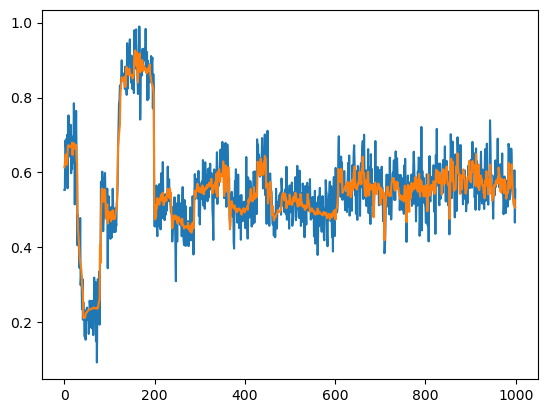

LeftGazeDirection_y


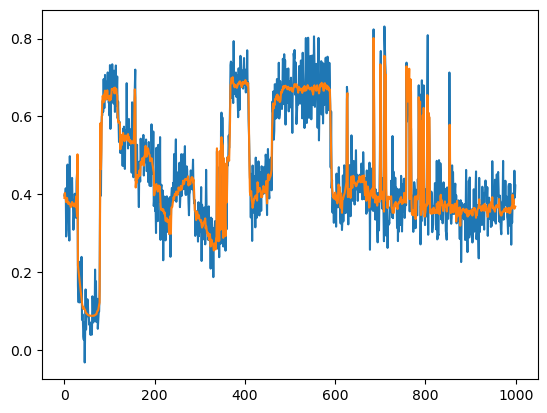

LeftGazeDirection_z


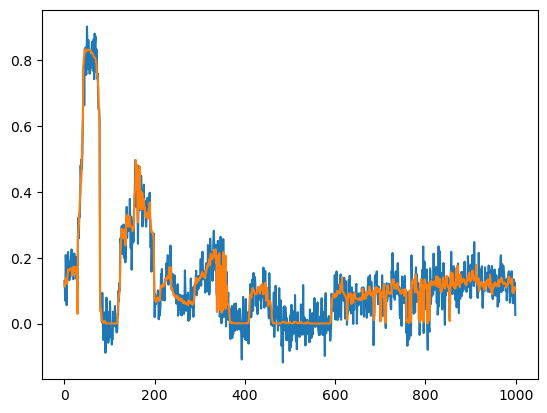

RightGazeDirection_x


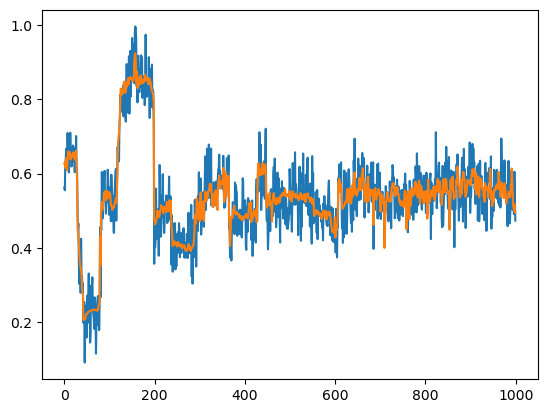

RightGazeDirection_y


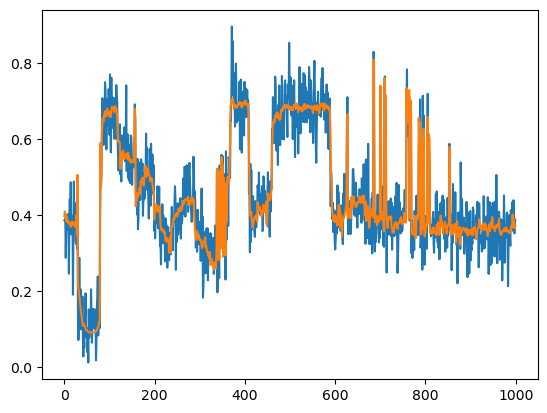

RightGazeDirection_z


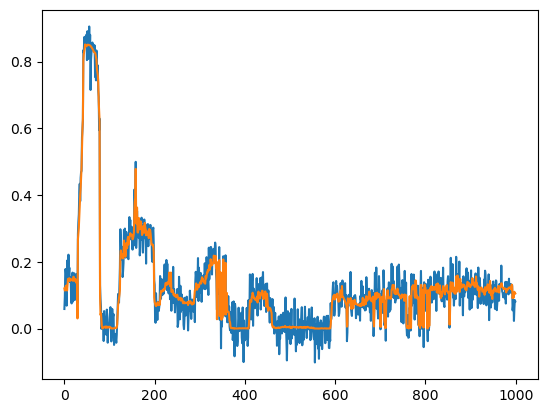

LeftGazeOrigin_x


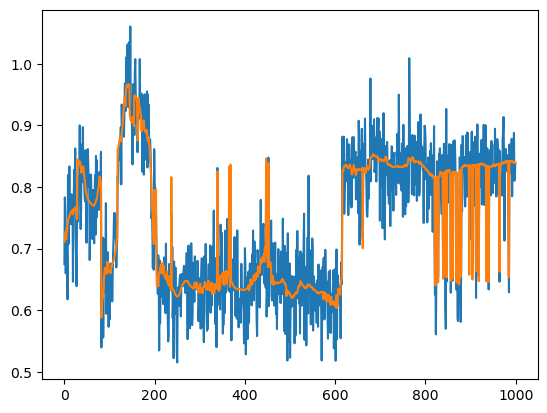

LeftGazeOrigin_y


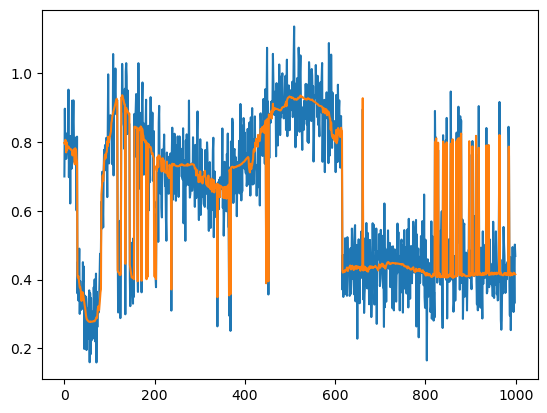

LeftGazeOrigin_z


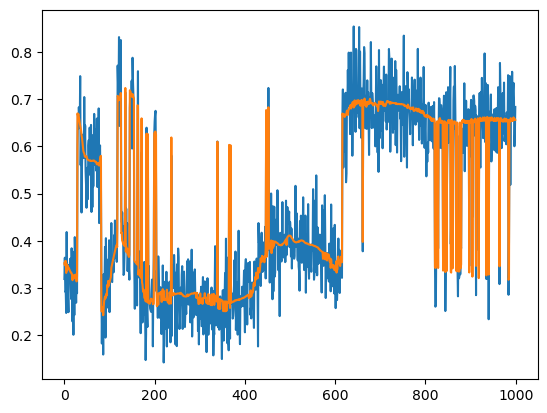

RightGazeOrigin_x


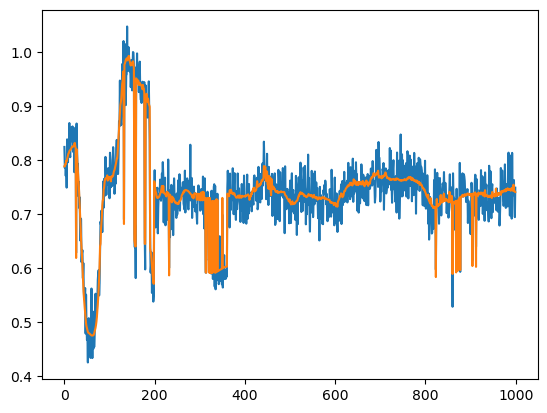

RightGazeOrigin_y


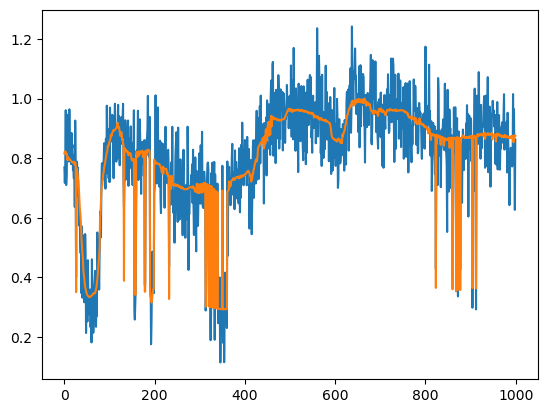

RightGazeOrigin_z


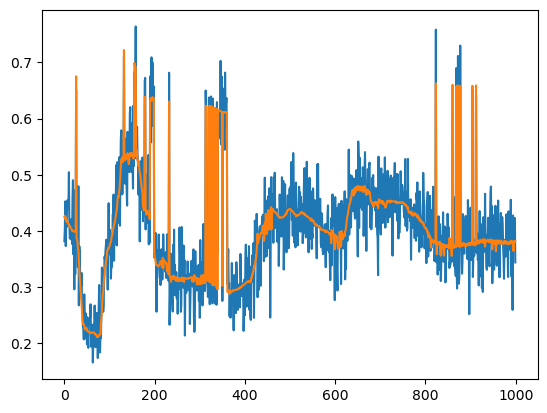

LeftEyelidOpening


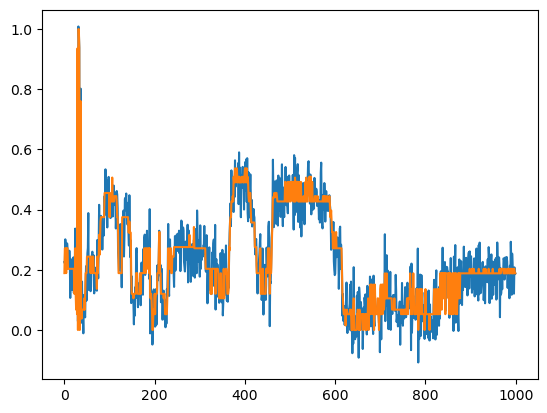

RightEyelidOpening


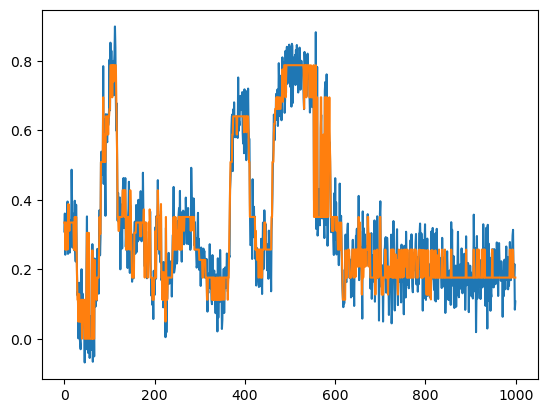

Dataset Shape: (120000, 64, 14) (120000, 3)
Gathering sequences for the validation dataset.

LeftGazeDirection_x


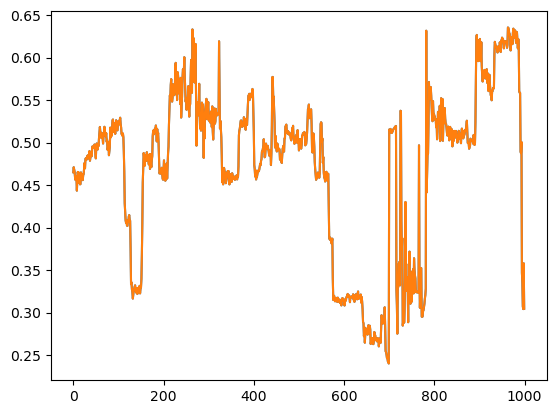

LeftGazeDirection_y


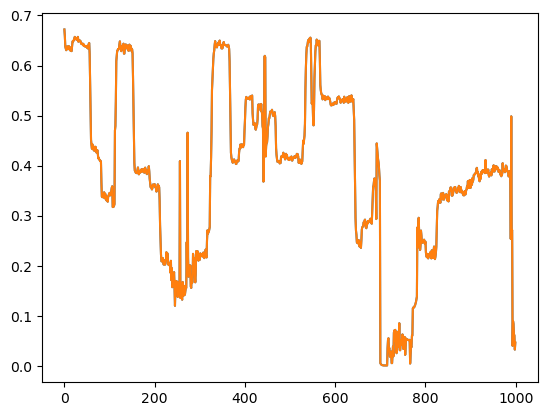

LeftGazeDirection_z


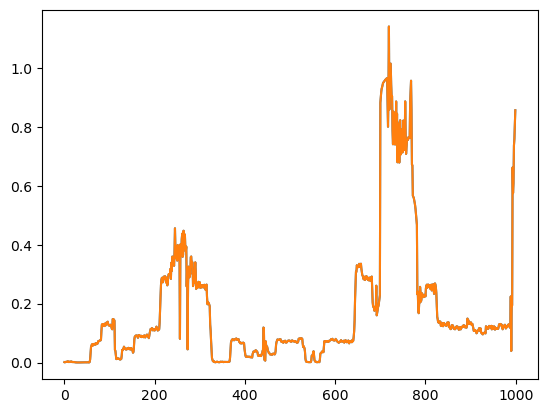

RightGazeDirection_x


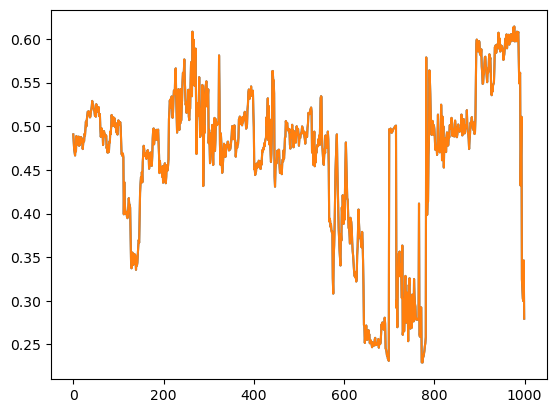

RightGazeDirection_y


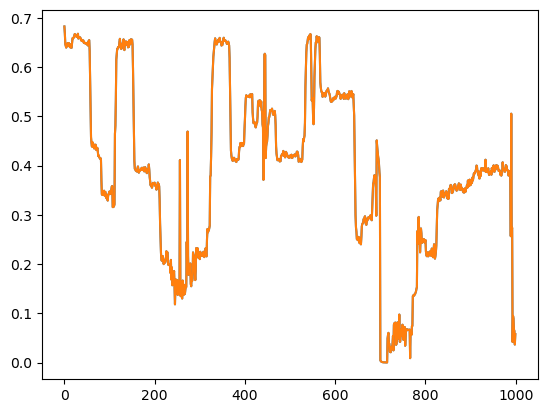

RightGazeDirection_z


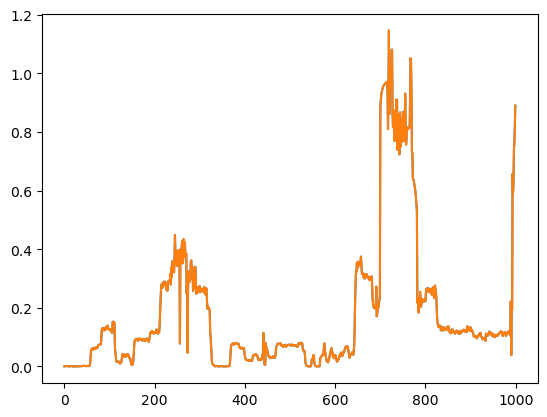

LeftGazeOrigin_x


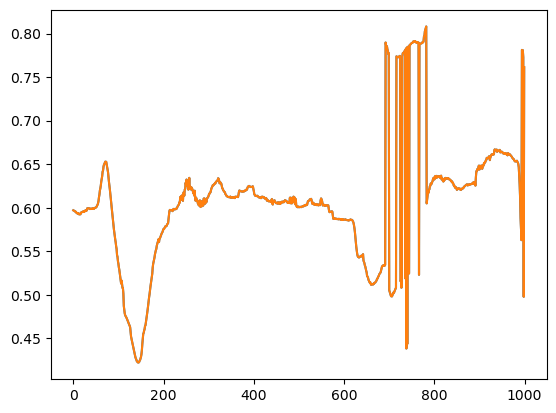

LeftGazeOrigin_y


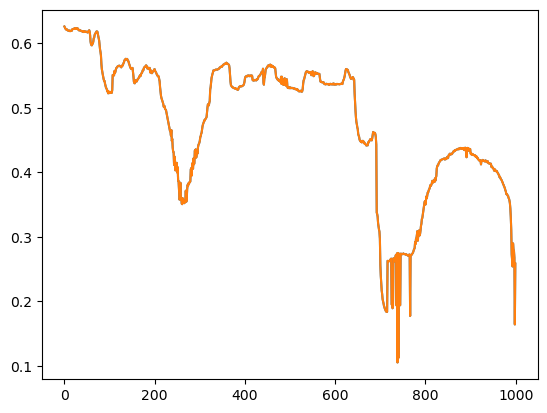

LeftGazeOrigin_z


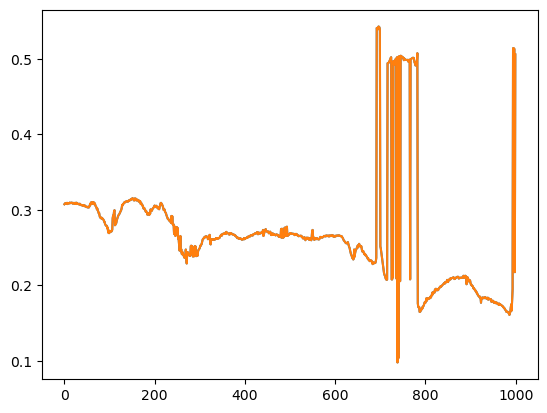

RightGazeOrigin_x


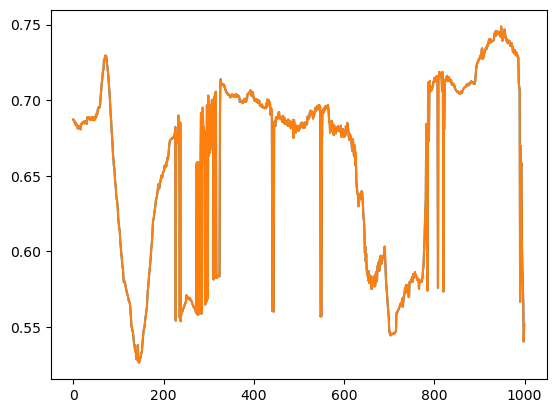

RightGazeOrigin_y


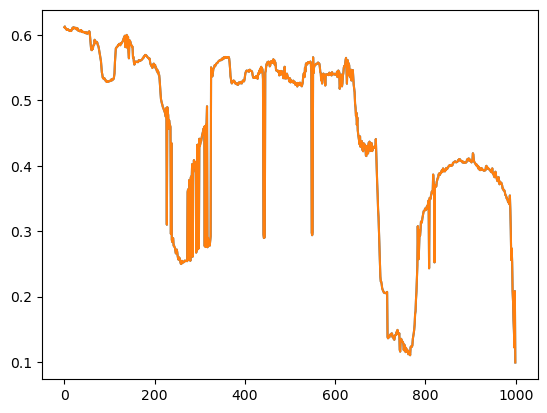

RightGazeOrigin_z


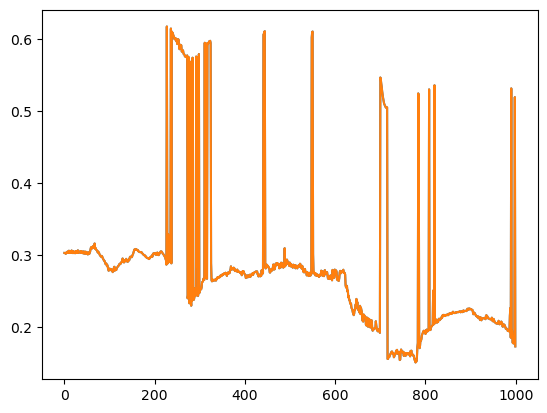

LeftEyelidOpening


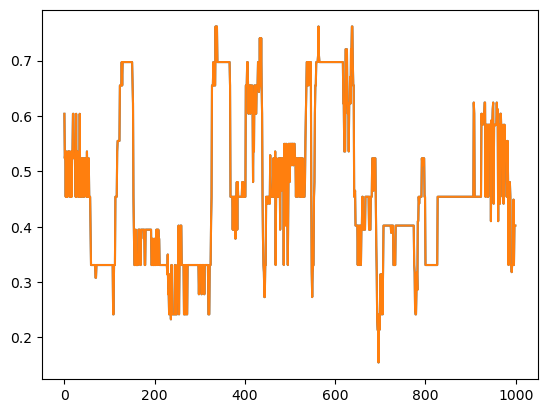

RightEyelidOpening


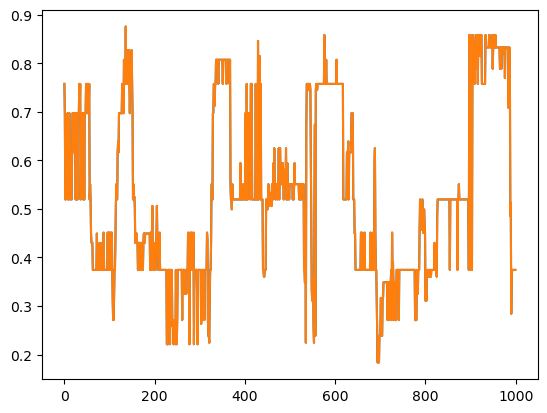

Dataset Shape: (20000, 64, 14) (20000, 3)
Current noise level is: 0.4
Epoch 1/200
3750/3750 [==============================] - 142s 36ms/step - loss: 0.0276 - val_loss: 0.0192
Epoch 2/200
3750/3750 [==============================] - 136s 36ms/step - loss: 0.0186 - val_loss: 0.0160
Epoch 3/200
3750/3750 [==============================] - 136s 36ms/step - loss: 0.0170 - val_loss: 0.0142
Epoch 4/200
3750/3750 [==============================] - 135s 36ms/step - loss: 0.0159 - val_loss: 0.0127
Epoch 5/200
3750/3750 [==============================] - 135s 36ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 6/200
3750/3750 [==============================] - 135s 36ms/step - loss: 0.0149 - val_loss: 0.0126
Epoch 7/200
3750/3750 [==============================] - 135s 36ms/step - loss: 0.0145 - val_loss: 0.0106
Epoch 8/200
3750/3750 [==============================] - 136s 36ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 9/200
3750/3750 [==============================] - 133s 35ms/step - loss: 0.

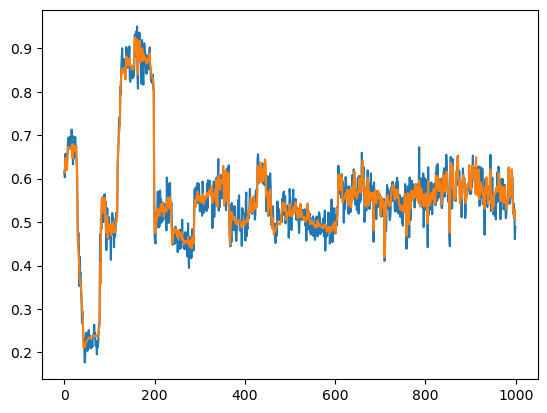

LeftGazeDirection_y


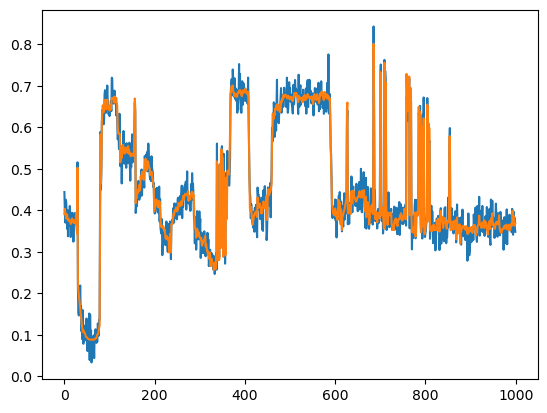

LeftGazeDirection_z


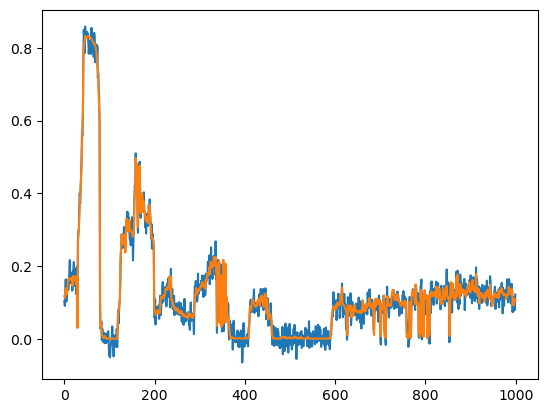

RightGazeDirection_x


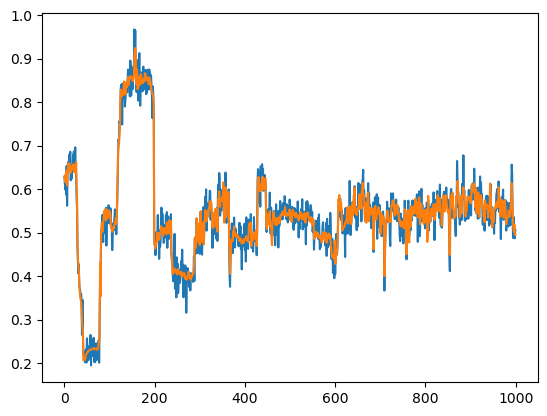

RightGazeDirection_y


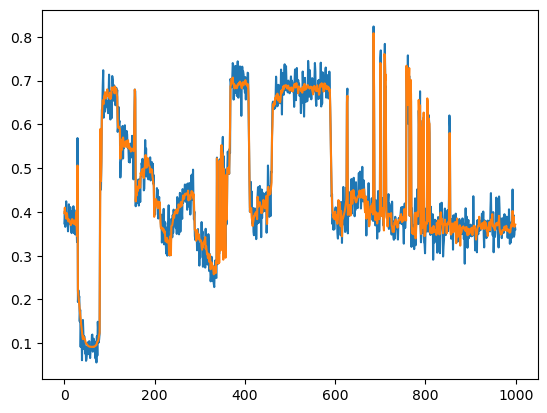

RightGazeDirection_z


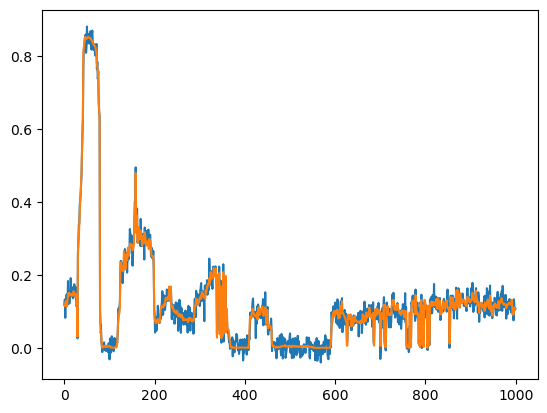

LeftGazeOrigin_x


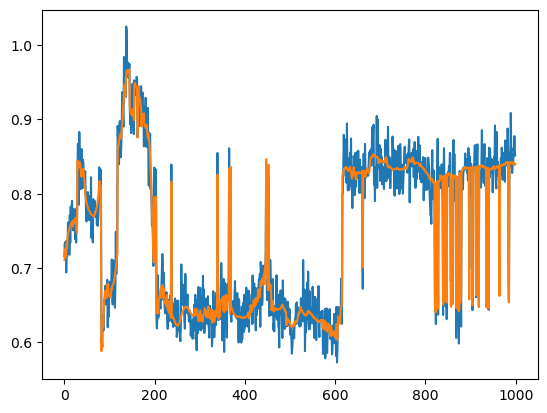

LeftGazeOrigin_y


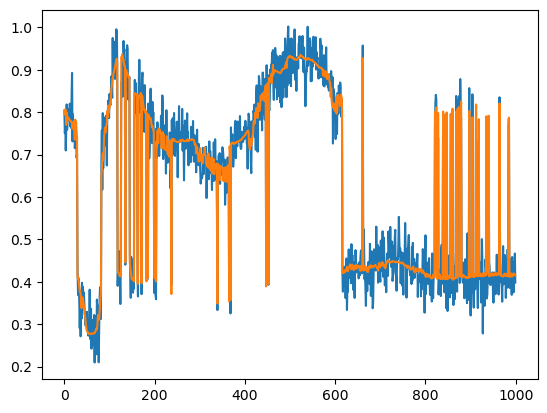

LeftGazeOrigin_z


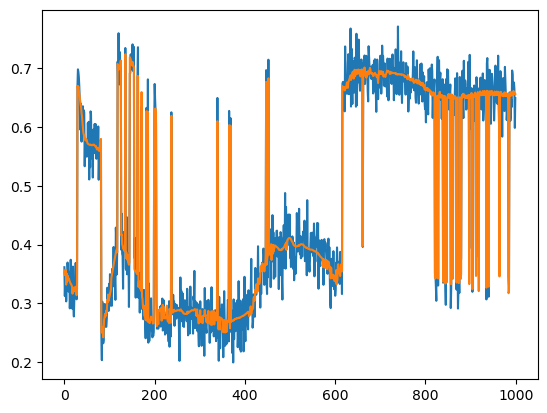

RightGazeOrigin_x


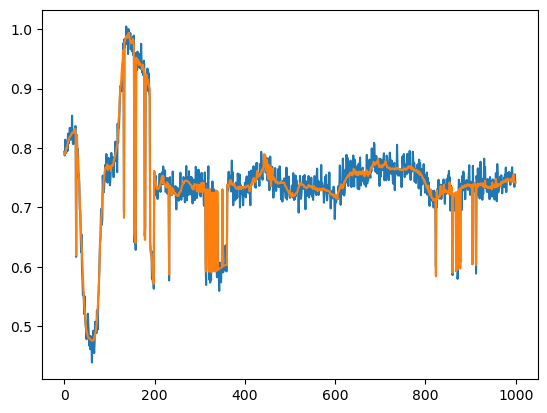

RightGazeOrigin_y


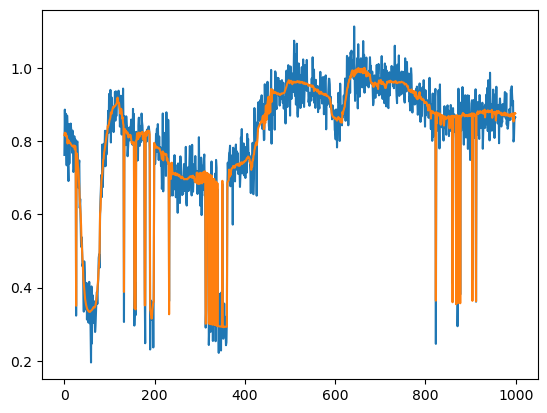

RightGazeOrigin_z


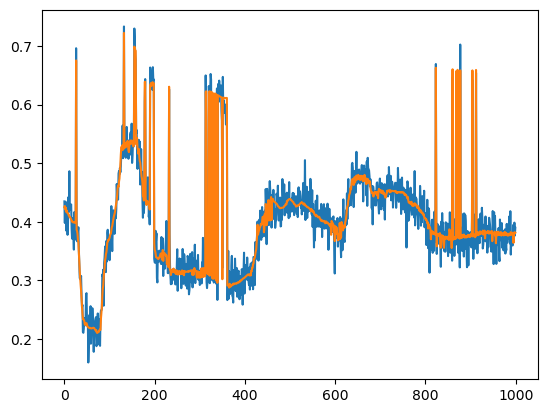

LeftEyelidOpening


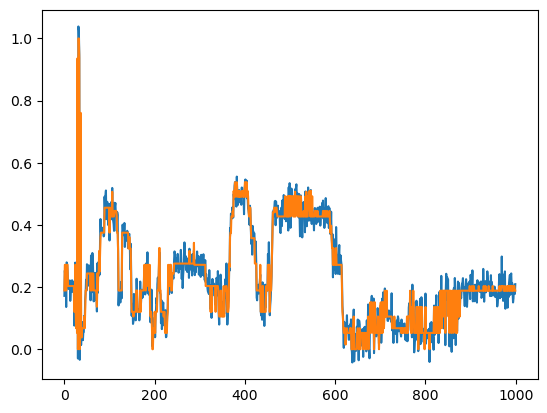

RightEyelidOpening


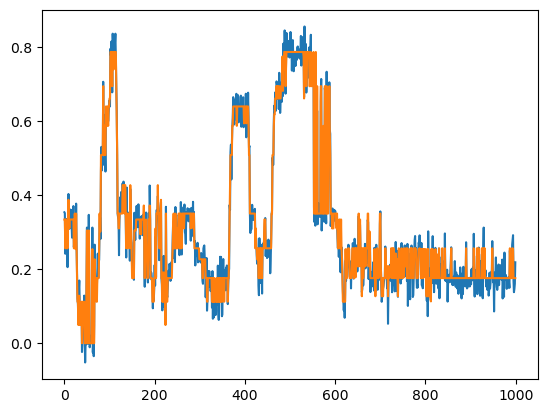

Dataset Shape: (120000, 64, 14) (120000, 3)
Gathering sequences for the validation dataset.

LeftGazeDirection_x


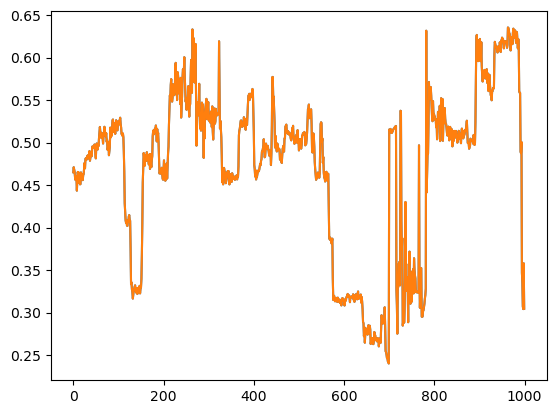

LeftGazeDirection_y


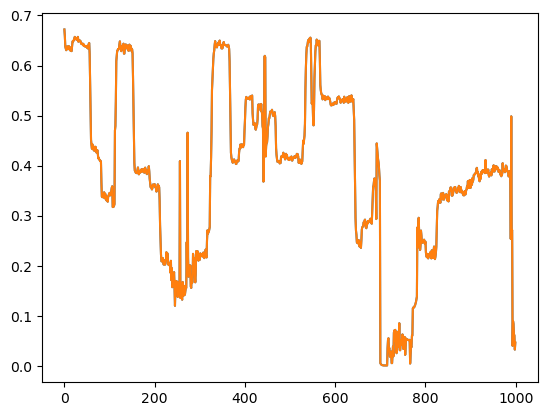

LeftGazeDirection_z


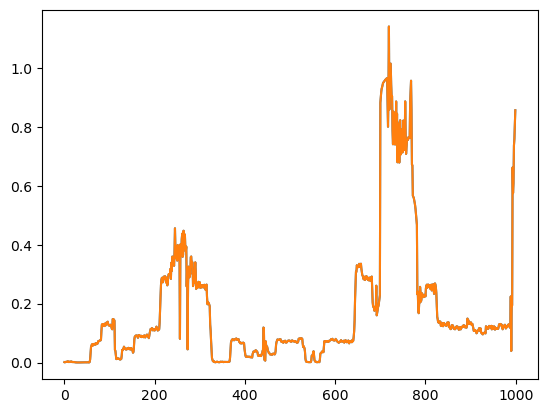

RightGazeDirection_x


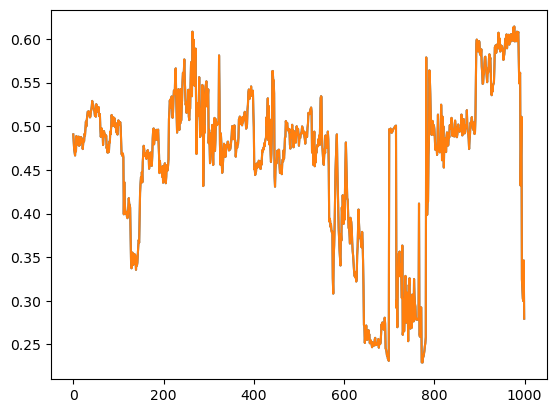

RightGazeDirection_y


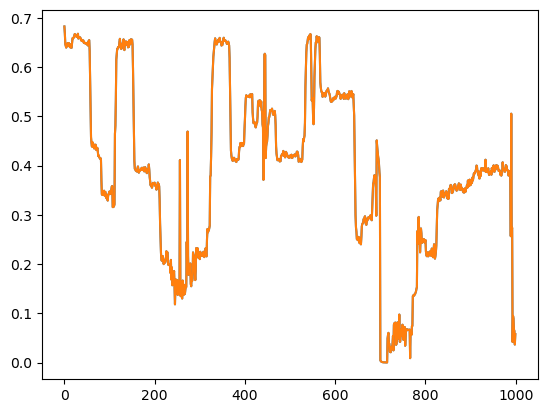

RightGazeDirection_z


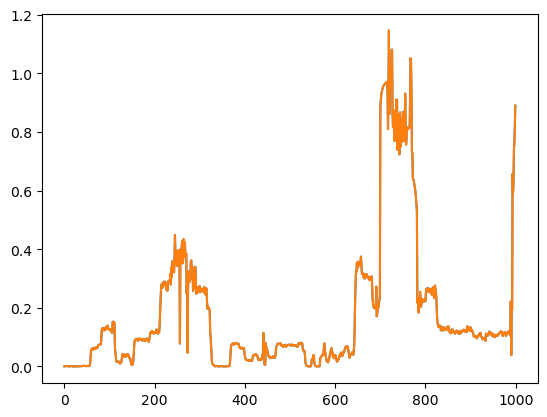

LeftGazeOrigin_x


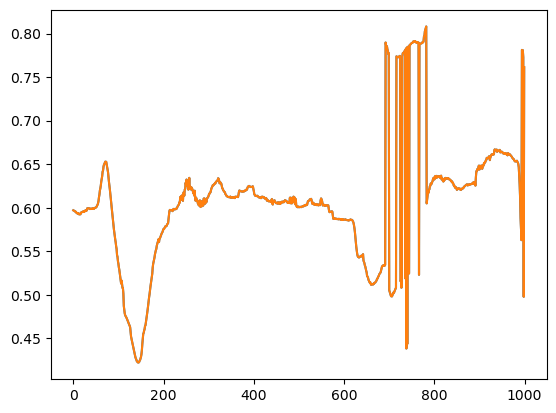

LeftGazeOrigin_y


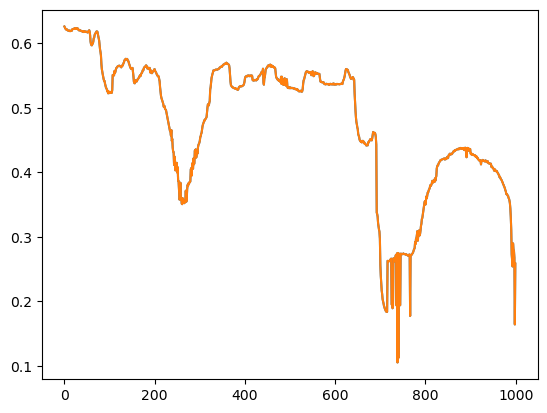

LeftGazeOrigin_z


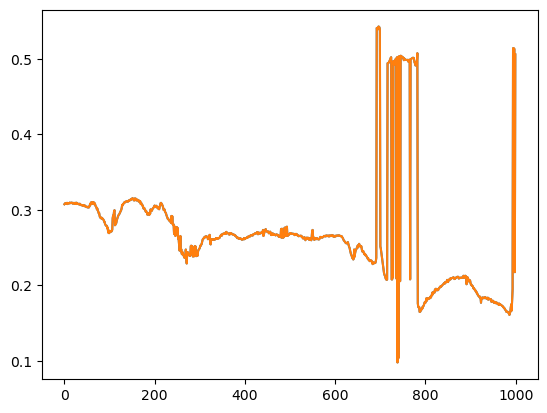

RightGazeOrigin_x


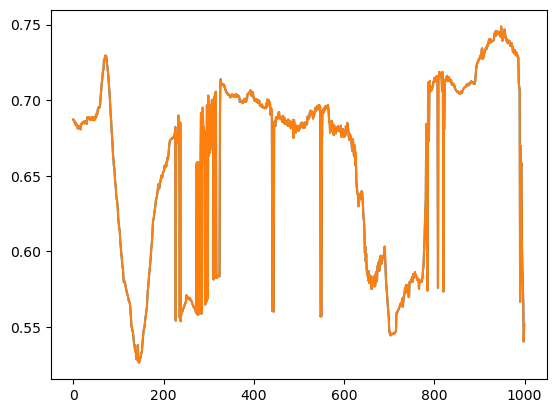

RightGazeOrigin_y


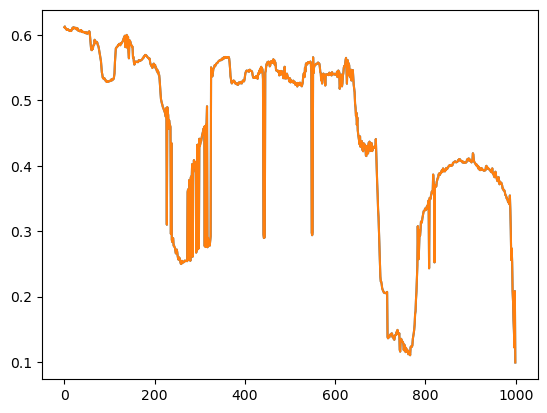

RightGazeOrigin_z


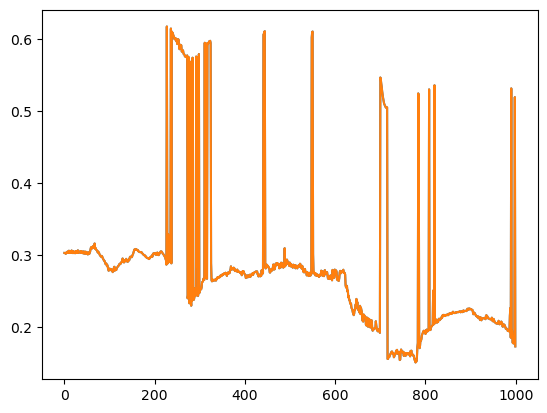

LeftEyelidOpening


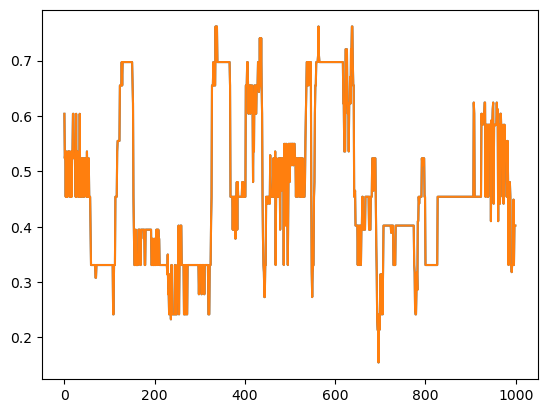

RightEyelidOpening


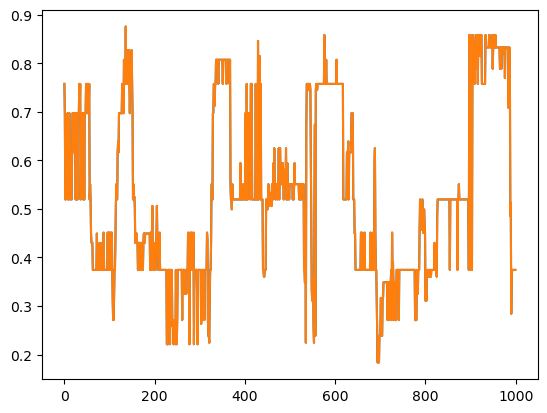

Dataset Shape: (20000, 64, 14) (20000, 3)
Current noise level is: 0.2
Epoch 1/200
3750/3750 [==============================] - 123s 33ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 2/200
3750/3750 [==============================] - 123s 33ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 3/200
3750/3750 [==============================] - 123s 33ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/200
3750/3750 [==============================] - 125s 33ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 5/200
3750/3750 [==============================] - 125s 33ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 6/200
3750/3750 [==============================] - 123s 33ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 7/200
3750/3750 [==============================] - 125s 33ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 8/200
3750/3750 [==============================] - 130s 35ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 9/200
3750/3750 [==============================] - 131s 35ms/step - loss: 0.

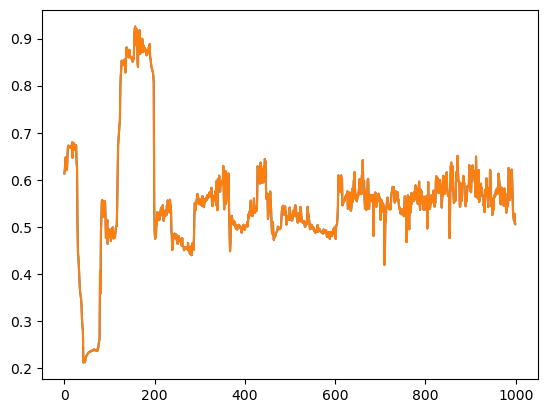

LeftGazeDirection_y


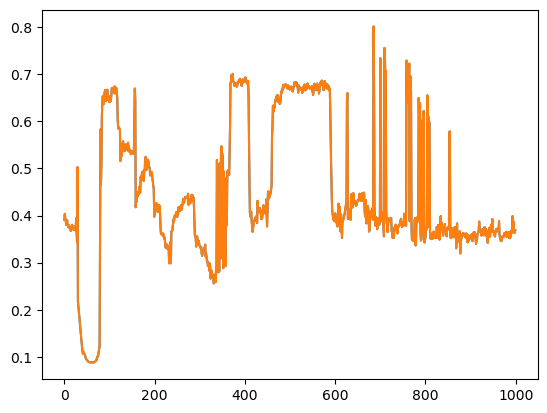

LeftGazeDirection_z


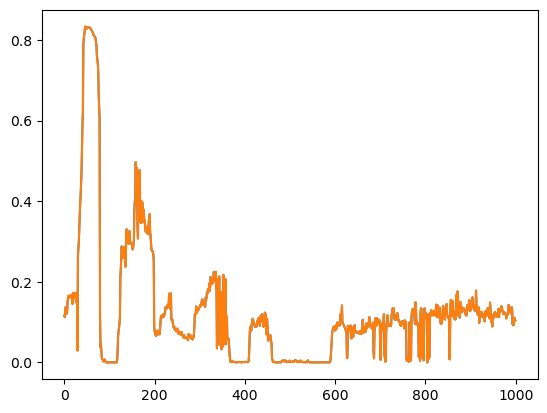

RightGazeDirection_x


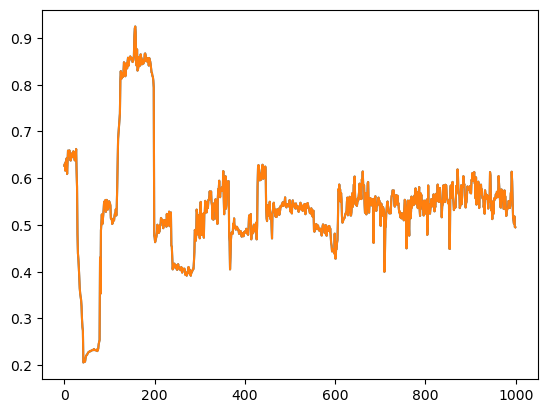

RightGazeDirection_y


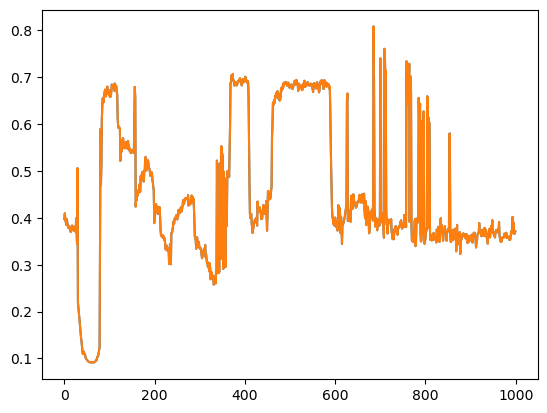

RightGazeDirection_z


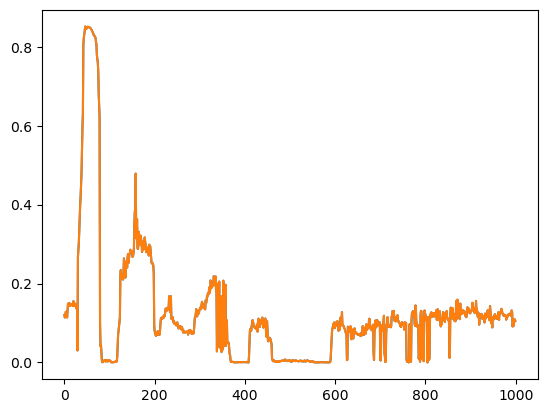

LeftGazeOrigin_x


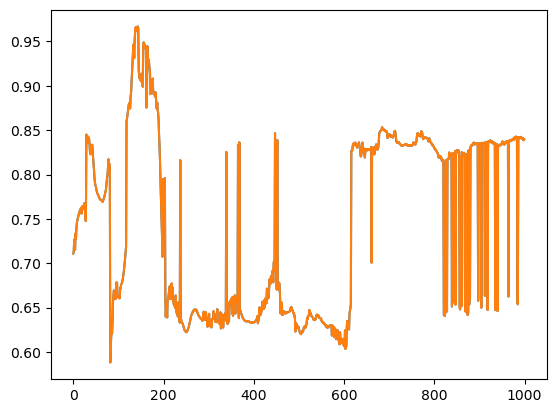

LeftGazeOrigin_y


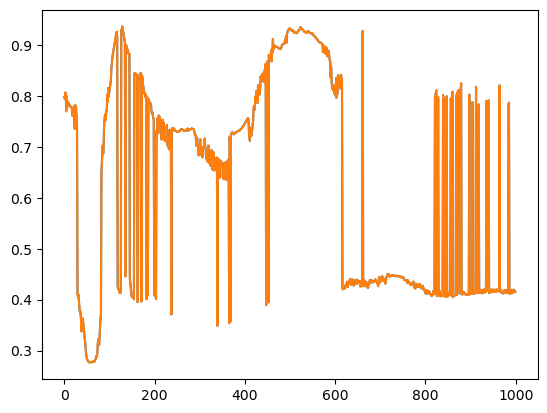

LeftGazeOrigin_z


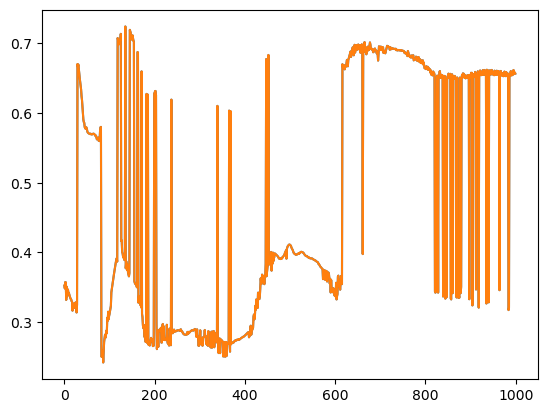

RightGazeOrigin_x


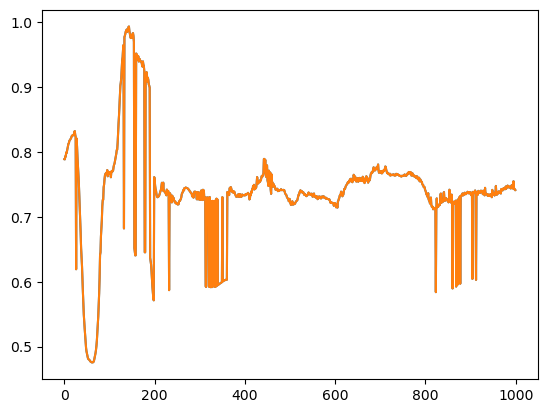

RightGazeOrigin_y


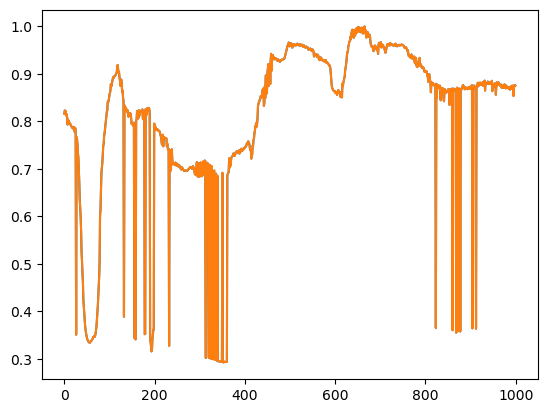

RightGazeOrigin_z


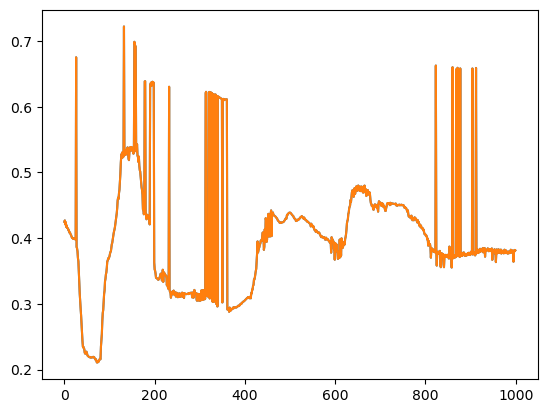

LeftEyelidOpening


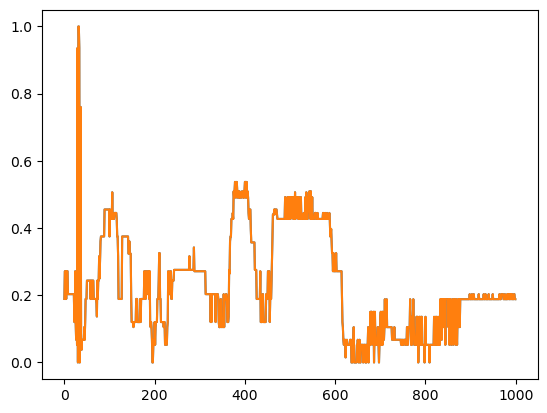

RightEyelidOpening


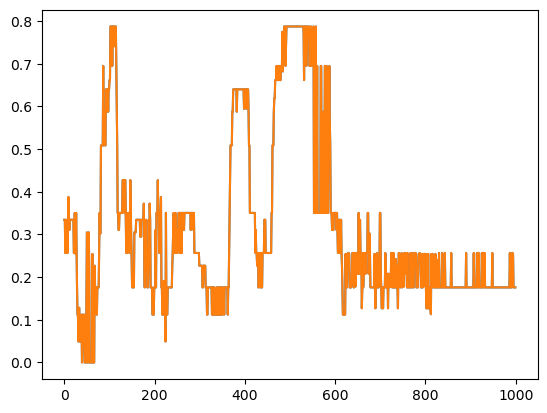

Dataset Shape: (120000, 64, 14) (120000, 3)
Gathering sequences for the validation dataset.

LeftGazeDirection_x


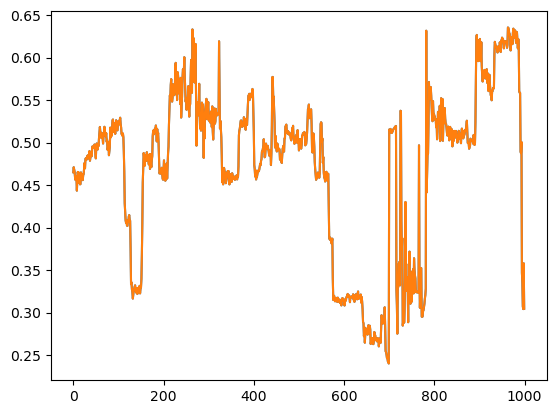

LeftGazeDirection_y


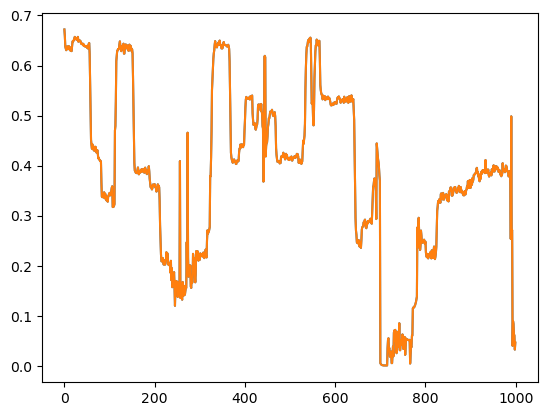

LeftGazeDirection_z


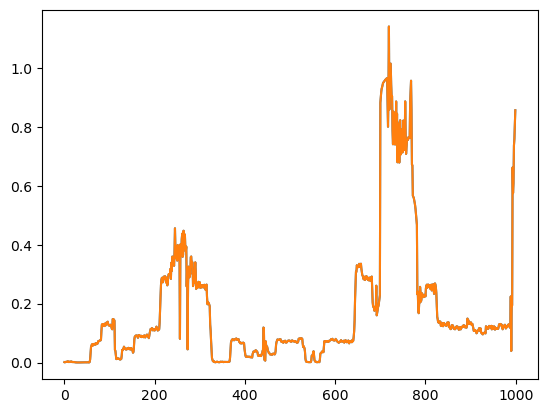

RightGazeDirection_x


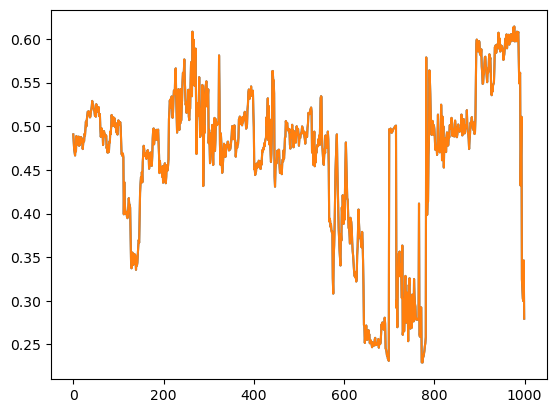

RightGazeDirection_y


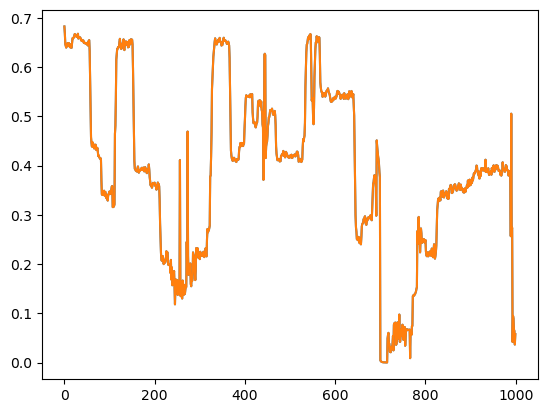

RightGazeDirection_z


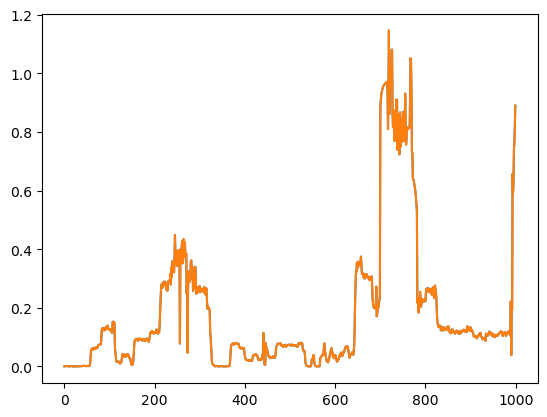

LeftGazeOrigin_x


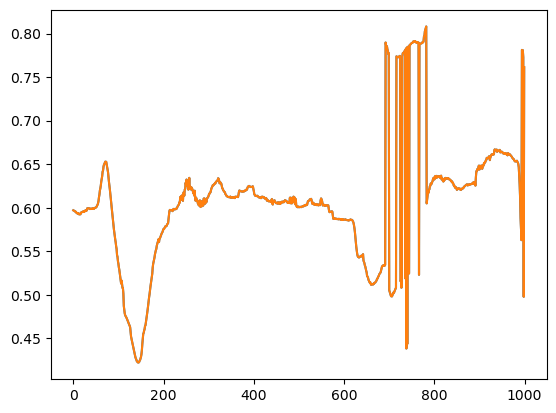

LeftGazeOrigin_y


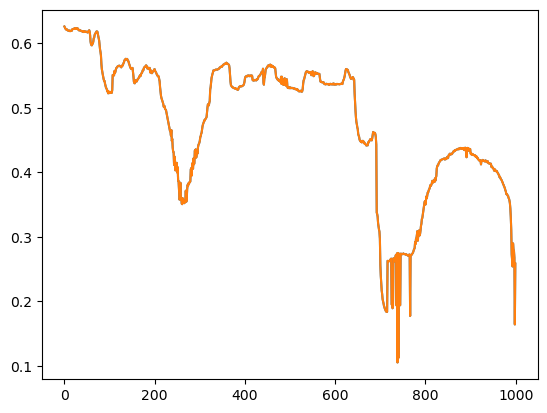

LeftGazeOrigin_z


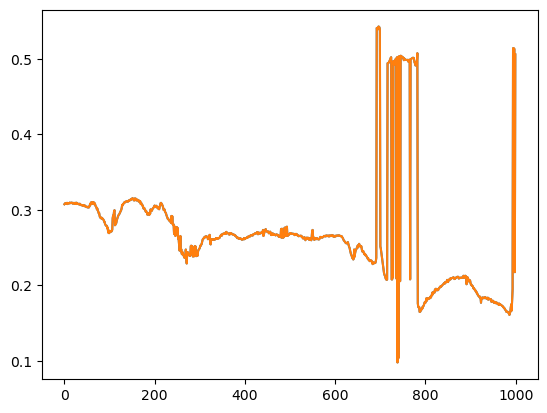

RightGazeOrigin_x


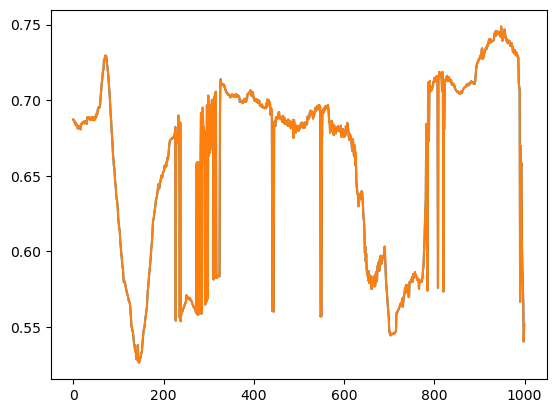

RightGazeOrigin_y


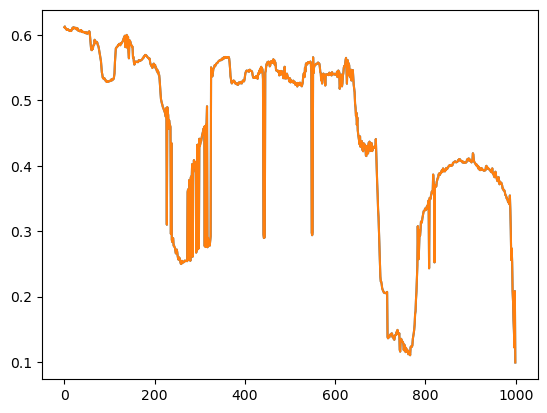

RightGazeOrigin_z


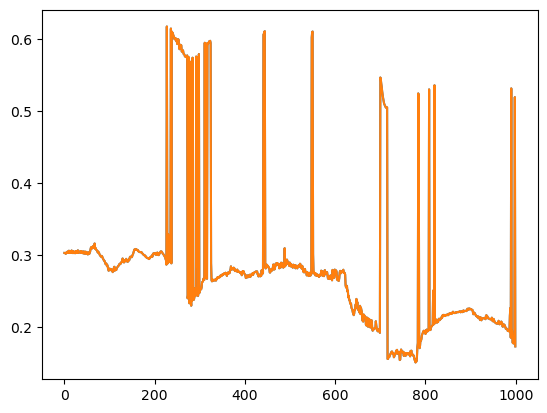

LeftEyelidOpening


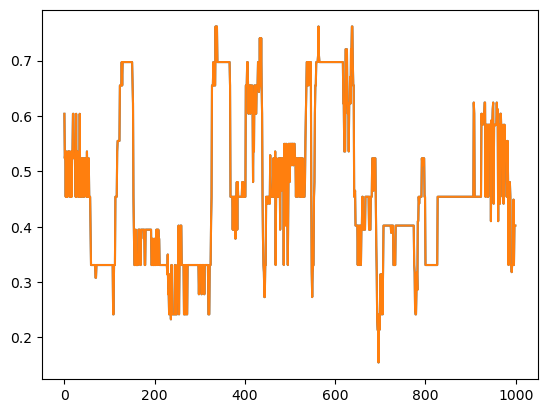

RightEyelidOpening


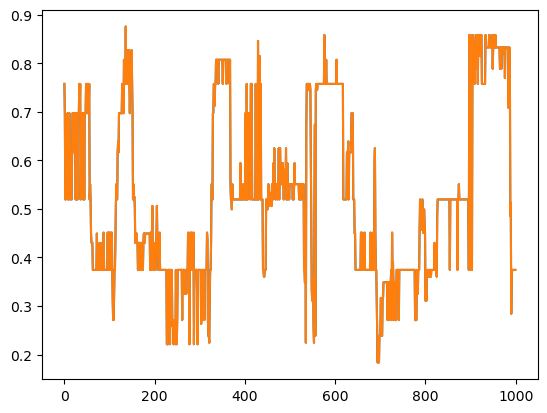

Dataset Shape: (20000, 64, 14) (20000, 3)
Current noise level is: 0.0
Epoch 1/200
3750/3750 [==============================] - 136s 36ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 2/200
3750/3750 [==============================] - 128s 34ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/200
3750/3750 [==============================] - 127s 34ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 4/200
3750/3750 [==============================] - 127s 34ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 5/200
3750/3750 [==============================] - 127s 34ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/200
3750/3750 [==============================] - 130s 35ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 7/200
3750/3750 [==============================] - 128s 34ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/200
3750/3750 [==============================] - 128s 34ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/200
3750/3750 [==============================] - 127s 34ms/step - loss: 0.

In [11]:
# train the model with an adaptive noise level (0.4 --> 0.2 --> 0.0)*stdev of the feature

train_eval = [] # itialize list to store training history at each noise level
for i in reversed(range(0,5,2)):
        
    scale = i/10 # set the noise level

    print("Gathering sequences for the training dataset.\n")
    train_x, train_y = dataprep(train_file_list, trainx_list, trainy_list, addnoise=True, scale=scale)
    
    print("Gathering sequences for the validation dataset.\n")
    # concatenate the validation data after selection of random sequences
    val_x, val_y = dataprep(val_file_list, valx_list, valy_list, addnoise=False, scale=scale)
    
    print("Current noise level is:", scale)

    # Train the TCN
    train_eval.append(model.fit(train_x, train_y,
                        validation_data=(val_x, val_y),
                        shuffle=True,
                        batch_size=32,
                        epochs=200,
                        verbose=1,
                        callbacks=[early_stop]))

#     del train_ds, val_ds

In [12]:
val_loss_total = []
loss_total = []

for history in train_eval:
    val_loss_total.append(history.history['val_loss'])
    loss_total.append(history.history['loss'])

val_loss_total = np.concatenate(val_loss_total, axis=0)
loss_total = np.concatenate(loss_total, axis=0)


Total Epochs = 140


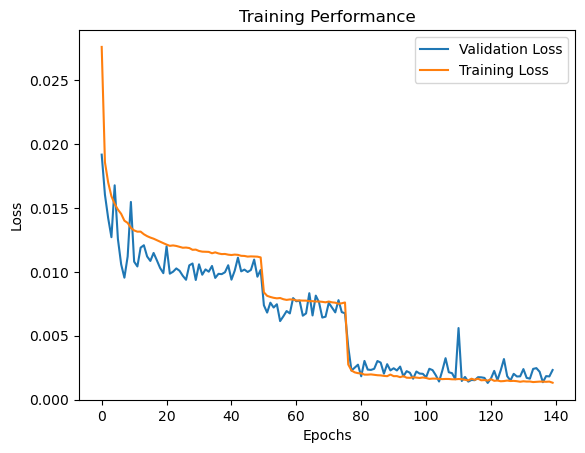

In [13]:
# Obtain number of epochs
epochs = range(len(loss_total))

print("Total Epochs =", len(epochs))

# Plot loss and val loss
plt.plot(val_loss_total, label='Validation Loss')
plt.plot(loss_total, label='Training Loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
# Save model
model.save("../Models/TCN")

INFO:tensorflow:Assets written to: ../Models/TCN3\assets


INFO:tensorflow:Assets written to: ../Models/TCN3\assets
